# Data Scraping

In [422]:
from selenium import webdriver
import pandas as pd
from bs4 import BeautifulSoup
from selenium.webdriver.chrome.options import Options
import time

In [423]:
# YouTube search URL
search_query = "python for beginners"
url = f"https://www.youtube.com/results?search_query={search_query.replace(' ', '+')}"

In [424]:
#Setting up Selenium Webdriver
chrome_options = Options()

#Initializing webdriver
driver=webdriver.Chrome(options=chrome_options)
driver.get(url)
time.sleep(10)  # Wait for the page to load

# Scroll to load more videos (Adjust the range for more videos)
for _ in range(15):  
    driver.execute_script("window.scrollBy(0, 1000);")
    time.sleep(2)

# Get page source and parse with BeautifulSoup
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

In [425]:
# Extract video details
videos = soup.find_all("ytd-video-renderer", limit=50)  # Get videos
data = []

for video in videos:
    title_tag = video.find("a", id="video-title")
    title = title_tag.text.strip() if title_tag else "N/A"
    link = f"https://www.youtube.com{title_tag['href']}" if title_tag else "N/A"

    channel_tag = video.find("a", class_="yt-simple-endpoint style-scope yt-formatted-string")
    channel = channel_tag.text.strip() if channel_tag else "N/A"

    duration_tag = video.find("span", class_="style-scope ytd-thumbnail-overlay-time-status-renderer")
    duration = duration_tag.text.strip() if duration_tag else "N/A"
    
    views_upload_tag = video.select("span.ytd-video-meta-block.style-scope")
    if len(views_upload_tag) > 1:
        views_text = views_upload_tag[0].text # First element contains views
        upload_text = views_upload_tag[1].text
    else:
        views_text = "N/A"  # Fallback if views are missing
        upload_text = "N/A"  

    data.append([title, channel, views_text, upload_text, duration, link])

In [426]:
# Save to Excel
df = pd.DataFrame(data, columns=["Title", "Channel", "Views", "Upload Time", "Duration", "Link"])
df.to_excel("YouTube_Videos.xlsx", index=False)
print("Data saved to YouTube_Videos.xlsx")

Data saved to YouTube_Videos.xlsx


In [427]:
df.shape

(45, 6)

# Data Preprocessing

In [428]:
data = pd.read_excel('Youtube_Videos.xlsx') 
data.head()

,Title,Channel,Views,Upload Time,Duration,Link
0,Python for Beginners - Learn Coding with Pytho...,Programming with Mosh,20M views,4 years ago,1:00:06,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...
1,Python Full Course for Beginners,Programming with Mosh,43M views,6 years ago,6:14:07,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...
2,Python Tutorial for Beginners | Learn Python i...,Apna College,10M views,3 years ago,1:17:12,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...
3,Python Part: 13|| Break and Continute in Pytho...,computer shagoofi,22 views,2 days ago,3:58,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...
4,Python Tutorial - Python Full Course for Begin...,Error Makes Clever,4.5M views,1 year ago,9:38:04,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...


In [429]:
data['Views'] = data['Views'].str.replace(" views","")   
views_new = [] 
for i in data['Views']:
    i=str(i)
    if(i.endswith('K')): 
        i = i.replace('K','') 
        views_new.append(float(i) * 1000) 
    else : 
        views_new.append(i) 
  
data['Views'] = views_new
data['Views'] = data['Views'].fillna(0)  # Replaces NaN with 0

In [430]:
duration_new = [] 
  
for i in data['Duration']: 
    if(i=='SHORTS'):
        duration_new.append(30)
    elif(len(str(i).split(':'))==1): 
        duration_new.append(i) 
    elif(len(i.split(':'))==2): 
        i = i.split(':') 
        time = int(i[0])*60 + int(i[1]) 
        duration_new.append(time) 
    elif(len(i.split(':'))==3): 
        i = i.split(':') 
        time = int(i[0])*3600 + int(i[1])*60 + int(i[2]) 
        duration_new.append(time) 
          
data['Duration'] = duration_new
data['Duration'] = data['Duration'].fillna(0)  # Replaces NaN with 0

In [431]:
# Categorize videos based on duration
def categorize_duration(sec):
    if sec == 30:
        return 'SHORTS'
    elif sec < 900:  # Less than 15 min
        return 'Mini-Videos'
    elif sec < 3600:  # Less than 1 hour
        return 'Long-Videos'
    else:
        return 'Very-Long-Videos'

# Create Category column
data['Category'] = data['Duration'].apply(categorize_duration)
data['Category'] = data['Category'].fillna(0)  # Replaces NaN with 0
data['Upload Time'] = data['Upload Time'].fillna(0)  # Replaces NaN with 0

In [432]:
# Append 's' at the end
data['Duration'] = [f"{d} s" for d in duration_new]

In [433]:
data.head()

,Title,Channel,Views,Upload Time,Duration,Link,Category
0,Python for Beginners - Learn Coding with Pytho...,Programming with Mosh,20M,4 years ago,3606 s,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...,Very-Long-Videos
1,Python Full Course for Beginners,Programming with Mosh,43M,6 years ago,22447 s,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...,Very-Long-Videos
2,Python Tutorial for Beginners | Learn Python i...,Apna College,10M,3 years ago,4632 s,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...,Very-Long-Videos
3,Python Part: 13|| Break and Continute in Pytho...,computer shagoofi,22,2 days ago,238 s,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...,Mini-Videos
4,Python Tutorial - Python Full Course for Begin...,Error Makes Clever,4.5M,1 year ago,34684 s,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...,Very-Long-Videos


# Text Pre-Processing

In [434]:
import re 
from tqdm import tqdm 
import nltk 
nltk.download('punkt') 
nltk.download('stopwords') 
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shree\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shree\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [435]:
def preprocess_text(text_data): 
    preprocessed_text = [] 
      
    for sentence in tqdm(text_data): 
        #Remove punctuations and anything other than whitespace and words
        sentence = re.sub(r'[^\w\s]', '', sentence) #re is regular expressions
        preprocessed_text.append(' '.join(token.lower() 
                                  for token in str(sentence).split() 
                                  if token not in stopwords.words('english'))) #Remove the stop words ["in","is","the"]
  
    return preprocessed_text 
    
preprocessed_review = preprocess_text(data['Title'].values) 
data['Title'] = preprocessed_review

100%|██████████| 35/35 [00:00<00:00, 230.47it/s]


In [436]:
data.shape

(35, 7)

In [437]:
data.head()

,Title,Channel,Views,Upload Time,Duration,Link,Category
0,python beginners learn coding python 1 hour,Programming with Mosh,20M,4 years ago,3606 s,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...,Very-Long-Videos
1,python full course beginners,Programming with Mosh,43M,6 years ago,22447 s,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...,Very-Long-Videos
2,python tutorial beginners learn python 15 hours,Apna College,10M,3 years ago,4632 s,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...,Very-Long-Videos
3,python part 13 break continute python computer...,computer shagoofi,22,2 days ago,238 s,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...,Mini-Videos
4,python tutorial python full course beginners t...,Error Makes Clever,4.5M,1 year ago,34684 s,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...,Very-Long-Videos


In [438]:
#Capitalize the title after text processing
data['Title'] = data['Title'].str.title()

In [439]:
data.head()

,Title,Channel,Views,Upload Time,Duration,Link,Category
0,Python Beginners Learn Coding Python 1 Hour,Programming with Mosh,20M,4 years ago,3606 s,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...,Very-Long-Videos
1,Python Full Course Beginners,Programming with Mosh,43M,6 years ago,22447 s,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...,Very-Long-Videos
2,Python Tutorial Beginners Learn Python 15 Hours,Apna College,10M,3 years ago,4632 s,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...,Very-Long-Videos
3,Python Part 13 Break Continute Python Computer...,computer shagoofi,22,2 days ago,238 s,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...,Mini-Videos
4,Python Tutorial Python Full Course Beginners T...,Error Makes Clever,4.5M,1 year ago,34684 s,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...,Very-Long-Videos


In [440]:
#Change the column order
data=data.iloc[:,[0, 1, 2, 3, 4, 6, 5]]
data.head()

,Title,Channel,Views,Upload Time,Duration,Category,Link
0,Python Beginners Learn Coding Python 1 Hour,Programming with Mosh,20M,4 years ago,3606 s,Very-Long-Videos,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...
1,Python Full Course Beginners,Programming with Mosh,43M,6 years ago,22447 s,Very-Long-Videos,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...
2,Python Tutorial Beginners Learn Python 15 Hours,Apna College,10M,3 years ago,4632 s,Very-Long-Videos,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...
3,Python Part 13 Break Continute Python Computer...,computer shagoofi,22,2 days ago,238 s,Mini-Videos,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...
4,Python Tutorial Python Full Course Beginners T...,Error Makes Clever,4.5M,1 year ago,34684 s,Very-Long-Videos,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...


# Data Visualization

In [441]:
import matplotlib.pyplot as plt

### 📊 Bar Chart: Top 10 Most Frequent Video Categories

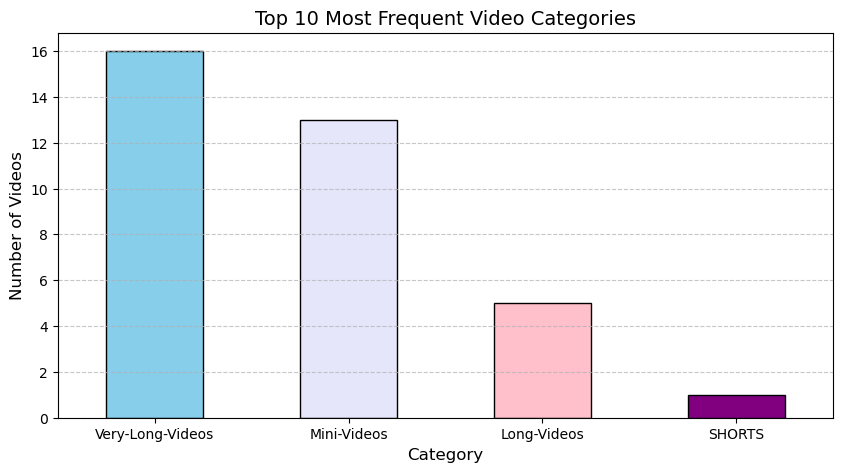

In [442]:
# Count the number of videos per category
category_counts = data['Category'].value_counts()

# Plot
plt.figure(figsize=(10, 5))
category_counts[:10].plot(kind='bar', color=['skyblue','lavender','pink','purple'], edgecolor='black')

plt.title("Top 10 Most Frequent Video Categories", fontsize=14)
plt.xlabel("Category", fontsize=12)
plt.ylabel("Number of Videos", fontsize=12)
plt.xticks(rotation=360)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### Pie Chart: Distribution of Video Categories

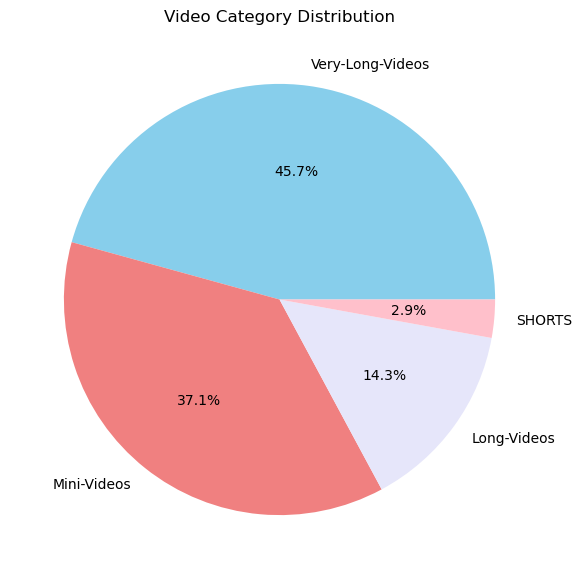

In [443]:
plt.figure(figsize=(7, 7))
category_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightcoral', 'lavender', 'pink'])

plt.title("Video Category Distribution")
plt.ylabel("")  # Hide the default y-label
plt.show()

### 3️⃣ Histogram: Distribution of Video Durations

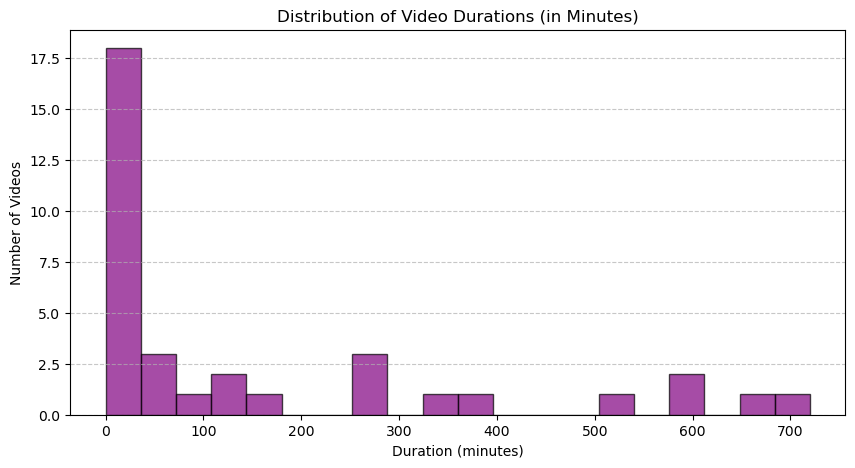

In [444]:
# Convert all values to string first to avoid AttributeError
a = data['Duration'].astype(str)

# Remove all non-numeric characters using regex
b = a.str.replace(r'\D', '', regex=True)

# Convert cleaned values to integers (handling NaN)
c= pd.to_numeric(b, errors='coerce').fillna(0).astype(int)

# Convert seconds to minutes
data['Duration_Min'] = c/ 60

plt.figure(figsize=(10, 5))
plt.hist(data['Duration_Min'], bins=20, color='purple', edgecolor='black', alpha=0.7)

plt.title("Distribution of Video Durations (in Minutes)")
plt.xlabel("Duration (minutes)")
plt.ylabel("Number of Videos")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 4️⃣ Scatter Plot: Relationship Between Views and Duration

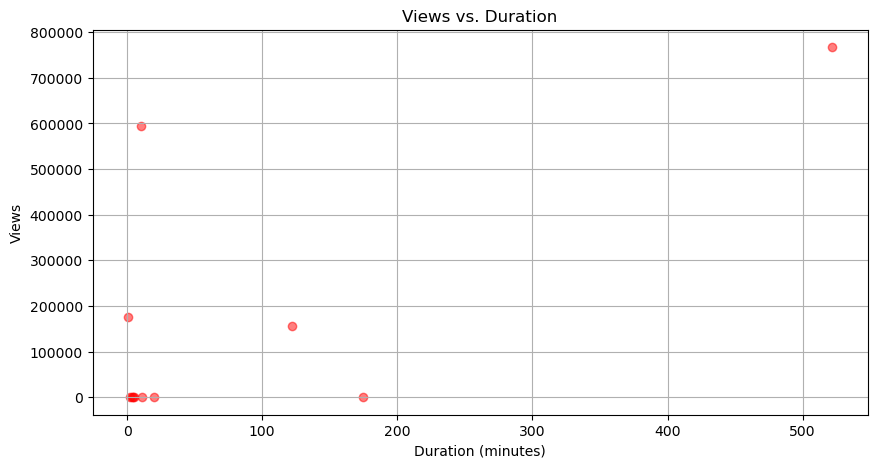

In [445]:
#Convert to numeric data
v = pd.to_numeric(data['Views'], errors='coerce')

plt.figure(figsize=(10, 5))
plt.scatter(data['Duration_Min'], v, alpha=0.5, color='red')

plt.title("Views vs. Duration")
plt.xlabel("Duration (minutes)")
plt.ylabel("Views")
plt.grid(True)
plt.show()

In [446]:
data.head()

,Title,Channel,Views,Upload Time,Duration,Category,Link,Duration_Min
0,Python Beginners Learn Coding Python 1 Hour,Programming with Mosh,20M,4 years ago,3606 s,Very-Long-Videos,https://www.youtube.com/watch?v=kqtD5dpn9C8&pp...,60.100000
1,Python Full Course Beginners,Programming with Mosh,43M,6 years ago,22447 s,Very-Long-Videos,https://www.youtube.com/watch?v=_uQrJ0TkZlc&pp...,374.116667
2,Python Tutorial Beginners Learn Python 15 Hours,Apna College,10M,3 years ago,4632 s,Very-Long-Videos,https://www.youtube.com/watch?v=vLqTf2b6GZw&pp...,77.200000
3,Python Part 13 Break Continute Python Computer...,computer shagoofi,22,2 days ago,238 s,Mini-Videos,https://www.youtube.com/watch?v=oSku7SuCRfM&pp...,3.966667
4,Python Tutorial Python Full Course Beginners T...,Error Makes Clever,4.5M,1 year ago,34684 s,Very-Long-Videos,https://www.youtube.com/watch?v=m67-bOpOoPU&pp...,578.066667
